<a href="https://colab.research.google.com/github/hikmatfarhat-ndu/CSC645/blob/master/kernas-cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolution Network

Convolution Neural Networks (CNN) have been very successful especially when modeling images. In this notebook we introduce CNNs and use Keras to learn the CIFAR10 data set

### Packages

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,datasets,models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten,BatchNormalization
## For embedding files in the notebook
#from IPython.display import IFrame

### Convolution Operations
We start with a simple example. Let I be an input image. Typically $I$ would be represented by a tensor of shape $(H,W,C)$ where $H$, $W$, and $C$ are the height, width, and color channel respectively. Therefore,  $I[h,w,c]$ refers to the value of channel $c$ in pixel $(h,w)$. Let $K$ be a filter with shape $(m,n)$ then the convolution operation produces the following tensor
\begin{align*}
T_{i,j}=\sum_c\sum_{m,n}X_{i+m,j+n,c}*K_{m,n}
\end{align*}
The above operation is illustrated in the example below. Click on the figures to see the sequence of operations.



In [13]:

%%HTML
<iframe src="https://docs.google.com/presentation/d/e/2PACX-1vQBSo0SLsiigeXPOP4MGOS55ez9hvRT0xWocjs16K7U4JMTD1UnHXrNAu43qRo_GQ/embed?start=true&loop=true&delayms=3000" frameborder="0" width="500" height="300" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>

In __general__ a convolution layer has multiple filters and each filter can have multiple output channels.

The input image data usually can be represented by a tensor of the form $X_{s,i,j,c}$ where $s$ is the index of the sample,$i$ the height,$j$ the width and $c$ the channel(color).

Let $s,i,j,f$ be the number of samples,output height index,output weight index, and the filter index respectively. The convolution operation is defined as
\begin{align*}
O_{s,i,j,f}=\sum_c\sum_{m,n}X_{s,i+m,j+n,c}*K_{m,n,c,f}
\end{align*}

Below we implement the operation we presented visually in the slides where a 2x2 filter operated on a 4x4 matrix ("image"). We use __one__ "image" sample with a __single__ color channel therefore the input has shape $(1,4,4,1)$.

Usually Keras(tensorflow) initializes the weigths of the filter using some random function but since we would like to use the kernel we showed in the visual example we need to supply and initialization function for the kernel

### Example


In [23]:
# This is used to initialize the weights
# of the kernel to the values we showed above
# on the slides
def my_init(shape,dtype=None):
  # since the input is of shape (1,2,2,1)
  # and we are using a single filter
  # we should return a tensor of shape (2,2,1,1)=(height,width,channel,filter)
  w=np.array([[1,-2],[-3,4]])
  # we add dimensions 3 and 4 for the input  channels and number of filters
  w=w.reshape(2,2,1,1)
  return w



input=np.array([[1,2,4,3],[5,6,8,7],[9,10,12,11],[13,14,16,2]],dtype=np.float32)
#since the first dimension is for the samples and the last is for the channels
#we reshape the input
input=input.reshape(1,4,4,1)
y= tf.keras.layers.Conv2D(1, 2 ,kernel_initializer=my_init,input_shape=input.shape[1:])(input)
print(y.shape)
#print sample 0 (it is the only one) first index=0 (row)
print(y)



(1, 3, 3, 1)
tf.Tensor(
[[[[  6.]
   [  8.]
   [  2.]]

  [[  6.]
   [  8.]
   [  2.]]

  [[  6.]
   [  8.]
   [-50.]]]], shape=(1, 3, 3, 1), dtype=float32)


### Another example
We modify the previous example to include three channels, similar to color images. To simplify, the "image" has the same value for all three color channels

In [26]:
def my_init(shape,dtype=None):
  x=np.array([[1,-2],[-3,4]])
  x=x.reshape(2,2,1)
  #stack three copies of x together, one for each channel
  #The shape is (height=axis 0,width=axis 1,channels=axis 2,num_filters=axis 3)
  x=np.stack([x,x,x],axis=2)
  return x
#x=np.ones((1,4,4),dtype=np.float32)
#print(x.shape)
#layer=tf.keras.layers.Conv2D(1,(2,2),input_shape=(4,4),kernel_initializer=tf.keras.initializers.Ones())
#y=layer(x[1:])
## expects the input shape of at least 4 dims=nsamples,height,width,depth
input=np.array([[1,2,4,3],[5,6,8,7],[9,10,12,11],[13,14,16,2]],dtype=np.float32)
input=input.reshape((1,4,4))
input=np.stack([input,input,input],axis=3)
y= tf.keras.layers.Conv2D(1, 2 ,kernel_initializer=my_init,input_shape=input.shape[1:])(input)
#print(y[0,2,:,:])
print(y)

(4, 4, 3)
tf.Tensor(
[[[[  18.       ]
   [  24.000004 ]
   [   6.0000105]]

  [[  17.999998 ]
   [  24.00001  ]
   [   5.999998 ]]

  [[  18.       ]
   [  24.000008 ]
   [-150.       ]]]], shape=(1, 3, 3, 1), dtype=float32)


## CNN for CIFAR 10

Now that we know what a convolution operation is and how the conv2D layer in Keras works we will build a Convolution Neural Network to recognize CIFAR10 images

### Data

The data is already included in the Keras datasets so retrieving it is simple

In [28]:
(img_train,label_train),(img_test,label_test)=tf.keras.datasets.cifar10.load_data()
img_train=img_train/255.0
img_test=img_test/255.0

170500096/170498071 [==============================] - 4s 0us/step


In [29]:
print("img_train shape={},label_train shape={}".format(img_train.shape,label_train.shape))
print("img_test shape={},label_test shape={}".format(img_test.shape,label_test.shape))


img_train shape=(50000, 32, 32, 3),label_train shape=(50000, 1)
img_test shape=(10000, 32, 32, 3),label_test shape=(10000, 1)


We have dealt with this dataset before but it is helpful to recall some of its properties. As can be seen from the above the training data contains 50000 samples and test data contains 10000 samples. The labels are numbers from 0 to 9. Below we plot the first 10 images and their corresponding labels.

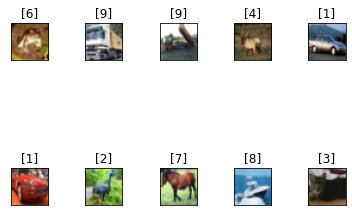

In [30]:
fig=plt.figure()
fig.tight_layout()
plt.subplots_adjust( wspace=1, hspace=1)

for i in range(0,10):
    img=img_train[i]    
    t=fig.add_subplot(2,5,i+1)
    t.set_title(str(label_train[i]))
    t.axes.get_xaxis().set_visible(False)
    t.axes.get_yaxis().set_visible(False)
    plt.imshow(img)

# Model

One can think of the input and output of convolution layers as **boxes** of the form (width,height,depth). Usually the depth of the input is the number of variables uses for colors e.g. 3. The output of a Conv2D of nfilters of size (x,y) is (width-x+1, height-y+1,nfilters) where we have assumed that the stride is 1

In [7]:
def createModel():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(.35))

    model.add(layers.Conv2D(64, (3, 3),  activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(.35))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    #model.add(Dropout(.35))

    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10,activation='softmax'))
    
    return model

In [8]:
def createModelA():
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size = (3,3), activation = 'elu', input_shape = (32, 32, 3)))
    model.add(Conv2D(64, kernel_size = (3,3), activation = 'elu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(.35))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=(3, 3), activation='elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='elu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.35))  
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(1024, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = 'softmax'))
    return model

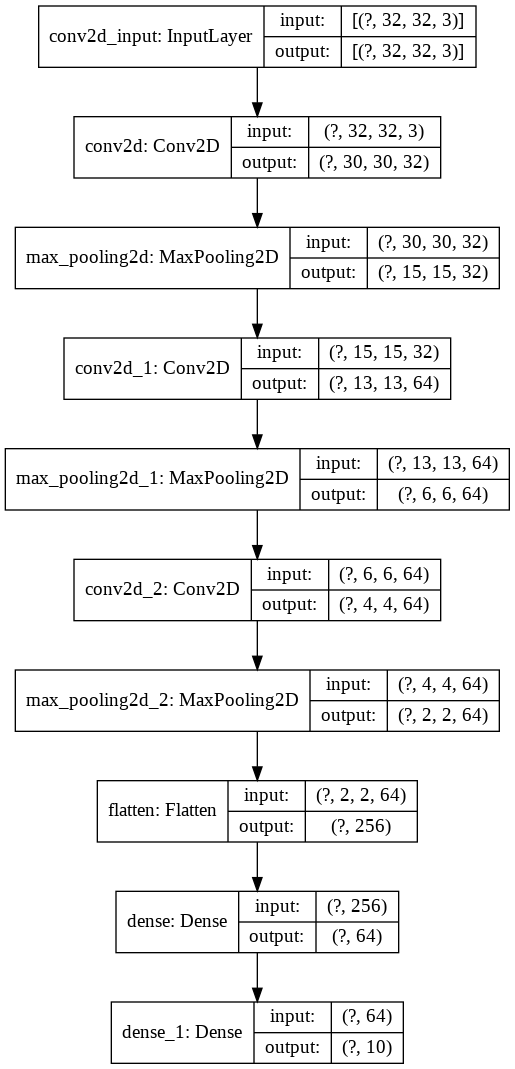

In [9]:
model=createModel()
tf.keras.utils.plot_model(model,show_shapes=True)

## Optimization

Keras can use many optimization method. In this notebook we use the __Adam__ method which can be described loosely as __adaptive__ gradient descent.

Also since the labels are __NOT__ in one_hot_encoding we use the "Sparse" version of the crossentropy loss: __SparseCategoricalCrossentropy__. Finally, if we don't specify from_logits=False then the loss function would compute softwmax before computing the loss

In [15]:
# if we don't use softmax in the last layer, i.e. if the output of the
# model is NOT probabilities then use from_logits=True
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(img_train,label_train, batch_size=128,epochs=10, 
                    validation_data=(img_test, label_test))


Epoch 1/10
391/391 [==============================] - 2s 6ms/step - loss: 0.6065 - accuracy: 0.7877 - val_loss: 0.8675 - val_accuracy: 0.7162
Epoch 2/10
391/391 [==============================] - 2s 5ms/step - loss: 0.5887 - accuracy: 0.7933 - val_loss: 0.9395 - val_accuracy: 0.6978
Epoch 3/10
391/391 [==============================] - 2s 5ms/step - loss: 0.5716 - accuracy: 0.7999 - val_loss: 0.8868 - val_accuracy: 0.7118
Epoch 4/10
391/391 [==============================] - 2s 5ms/step - loss: 0.5566 - accuracy: 0.8049 - val_loss: 0.9167 - val_accuracy: 0.7091
Epoch 5/10
391/391 [==============================] - 2s 5ms/step - loss: 0.5413 - accuracy: 0.8097 - val_loss: 0.9178 - val_accuracy: 0.7060
Epoch 6/10
391/391 [==============================] - 2s 5ms/step - loss: 0.5264 - accuracy: 0.8164 - val_loss: 0.9445 - val_accuracy: 0.7062
Epoch 7/10
391/391 [==============================] - 2s 5ms/step - loss: 0.5169 - accuracy: 0.8195 - val_loss: 0.9073 - val_accuracy: 0.7171
Epoch 

### Testing the Accuracy

In [11]:
_,test_accuracy=model.evaluate(img_test,label_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.9256 - accuracy: 0.6871


### Accessing Intermediate Layers

In [12]:
from keras import backend as K

# a function that returns a list of **One** element
first_layer_output = K.function([model.layers[0].input],
                                  [model.layers[0].output])
print(type(first_layer_output))
layer_output = first_layer_output(img_test)[0]
print(layer_output.shape)
print(type(layer_output))
second_layer_output=K.function([model.layers[0].input],
                                  [model.layers[1].output])
layer_output = second_layer_output(img_test)[0]

third_layer_output=K.function([model.layers[0].input],
                                  [model.layers[1].output])
layer_output = third_layer_output(img_test)[0]
print(layer_output.shape)

print("----------------------")


<class 'function'>
(10000, 30, 30, 32)
<class 'numpy.ndarray'>
(10000, 15, 15, 32)
----------------------


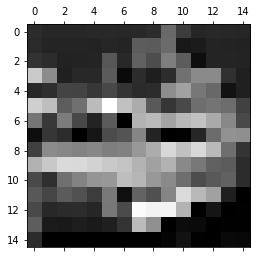

In [13]:
plt.matshow(layer_output[1,:,:,0],cmap="gray")